Importing modules

In [ ]:
!pip install arrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.0 MB/s eta 0:00:00


In [ ]:
import pymc as pm

In [ ]:
pm.gp.cov.Exponential(2,4)

In [ ]:
from jax import config

config.update("jax_enable_x64", True)

# import gpjax as gpx
from jax import grad, jit
import jax.numpy as jnp
import jax.random as jr
import optax as ox

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider
import ipywidgets as widgets
import jax.numpy as jnp
from jax import lax,vmap

In [ ]:
from tqdm import tqdm

In [ ]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
# from jax.scipy.special import gammaln, kv

In [ ]:
import sys
# import utils
import arrow
import numpy as np
from tqdm import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt

# **Temporal Parametric Kernels**

$EXP(α,β) = α e^{-βt}$


In [ ]:
class ExpKernel(object):
    """
    Kernel function including the diffusion-type model proposed by Musmeci and
    Vere-Jones (1992).
    """
    def __init__(self, alpha=1., beta=1.):
        self.alpha = alpha
        self.beta = beta

    def nu(self, t, his_t):
        delta_t = t - his_t
        return self.alpha * jnp.exp(- self.beta * delta_t)

$PWL(K,c,p)=\frac{K}{(t+c)^p}$

In [ ]:
class PowerKernel(object):
    """
    Kernel function based on the power kernel.
    """
    def __init__(self, K=1. ,c=1. ,p=1.):
        self.K = K
        self.c = c
        self.p = p

    def nu(self, t, his_t):
        delta_t = t - his_t
        return self.K/jnp.power((self.c + delta_t),self.p)

$QEXP(a,q)=\begin{cases}
    ae^{-t} & \text{if } q = 1 \\
    a [1 + (q - 1)t]^{\frac{1}{1-q}} & \text{if } q \neq 0 \text{ and } 1 + (1 - q)t > 0 \\
    0 & \text{if } q \neq 0 \text{ and } 1 + (1 - q)t \leq 0
\end{cases}$

In [ ]:
class TsallisQExpKernel(object):
    """
    Kernel function based on the Tsallis Q-Exponential function.
    """
    def __init__(self, a=1.0, q=1.0):
        self.a = a
        self.q = q

    def nu(self, t, his_t):
        delta_t = t - his_t
        if self.q == 1.0:
            return self.a * jnp.exp(self.a * delta_t)
        elif self.q != 0 and (1+(1-self.q)*delta_t)>0:
            return self.a + jnp.power(1 + (self.q - 1)*t),(1/(1-self.q))
        else:
            return 0

In [ ]:
class TsallisQExpKernel(object):
    """
    Kernel function based on the Tsallis Q-Exponential function.
    """
    def __init__(self, a=1.0, q=1.0):
        self.a = a
        self.q = q

    def nu(self, t, his_t):
        delta_t = t - his_t
        # delta_t = jnp.expand_dims(delta_t,axis=1)
        # Define the functions to compute the result for each branch
        def branch1(delta_t):
            return self.a * jnp.exp(self.a * delta_t)
        def branch2(delta_t):
            return self.a + jnp.power(1 + (self.q - 1) * t, 1 / (1 - self.q))
        def branch3(delta_t):
            return 0

        # Define the condition for each branch
        result_fn = lambda dt: lax.cond(jnp.equal(self.q,1), branch1, lax.cond(jnp.logical_and(self.q != 0, (1 + (1 - self.q) * dt) > 0), branch2, branch3, dt), dt)
        # condition1 = self.q == 1.0
        # condition2 = jnp.logical_and(self.q != 0, (1 + (1 - self.q) * delta_t) > 0)

        # cond = lambda cond1, cond2: lax.cond(cond1, branch1, lax.cond(cond1, branch2, branch3))
        # vcond = vmap(cond)

        # Use jax.lax.cond to conditionally choose between branches
        vresults = vmap(result_fn)
        result = vresults(delta_t)
        return result


In [ ]:
class PeriodicKernel(object):
    """
    Kernel function based on the periodic kernel.
    """
    def __init__(self, period=1.0):
        self.period = period

    def nu(self, t, his_t):
        delta_t = t - his_t
        return jnp.cos(2 * jnp.pi * delta_t / self.period)

In [ ]:
class GaussianKernel(object):
    """
    Kernel function based on the Gaussian kernel.
    """
    def __init__(self, alpha=1.0, sigma=1.0):
        self.alpha = alpha
        self.sigma = sigma

    def nu(self, t, his_t):
        delta_t = t - his_t
        return self.alpha * jnp.exp(-0.5 * (delta_t / self.sigma)**2)

In [ ]:
class LogisticKernel(object):
    """
    Kernel function based on the logistic kernel.
    """
    def __init__(self, alpha=1.0, beta=1.0):
        self.alpha = alpha
        self.beta = beta

    def nu(self, t, his_t):
        delta_t = t - his_t
        return self.alpha / (1 + jnp.exp(-self.beta * delta_t))

In [ ]:
class RectangularKernel(object):
    """
    Kernel function based on the rectangular kernel.
    """
    def __init__(self, width=1.0):
        self.width = width

    def nu(self, t, his_t):
        delta_t = t - his_t
        return jnp.where(jnp.abs(delta_t) <= self.width / 2, 1.0 / self.width, 0.0)

# **Spatio Temporal Parametric Kernels**

In [ ]:
class StdDiffusionKernel(object):
    """
    Kernel function including the diffusion-type model proposed by Musmeci and
    Vere-Jones (1992).
    """
    def __init__(self, C=1., beta=1., sigma_x=1., sigma_y=1.):
        self.C = C
        self.beta = beta
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y

    def nu(self, t, s, his_t, his_s):
        delta_s = s - his_s
        delta_t = t - his_t
        delta_x = delta_s[:, 0]
        delta_y = delta_s[:, 1]
        return jnp.exp(- self.beta * delta_t) * \
            (self.C / (2 * jnp.pi * self.sigma_x * self.sigma_y * delta_t)) * \
            jnp.exp((- 1. / (2 * delta_t)) * \
                ((jnp.square(delta_x) / jnp.square(self.sigma_x)) + \
                (jnp.square(delta_y) / jnp.square(self.sigma_y))))

In [ ]:
# Initialize an instance of ExpKernel
kernel = ExpKernel(alpha=2)

# Example usage:
# Generate random input data
rng_key = random.PRNGKey(123)
t = jnp.zeros(10)
his_t = jnp.arange(1, 11)

# Compute the kernel values
kernel_values = kernel.nu(t, his_t)
print(kernel_values)

[5.43656366e+00 1.47781122e+01 4.01710738e+01 1.09196300e+02
 2.96826318e+02 8.06857587e+02 2.19326632e+03 5.96191597e+03
 1.62061679e+04 4.40529316e+04]


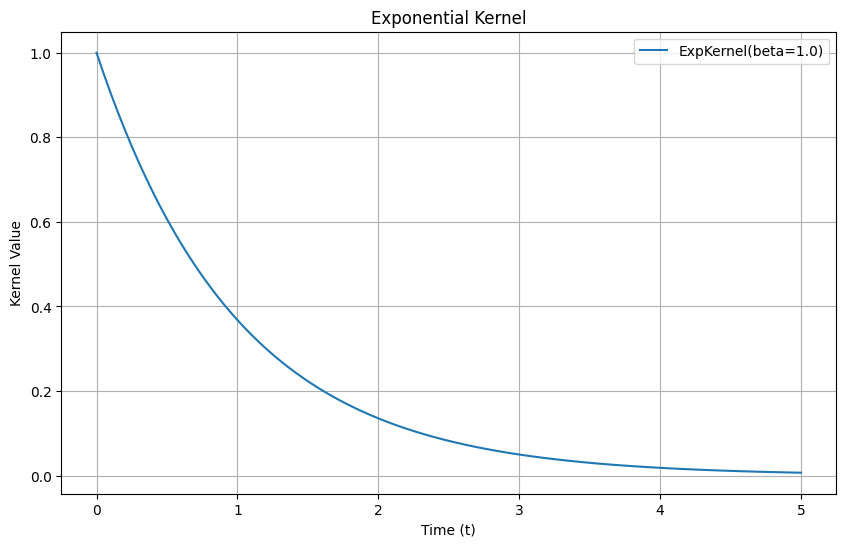

In [ ]:
kernel = ExpKernel(beta=1.0)

# Example inputs
t = jnp.linspace(0, 5, 100)  # Time values
his_t = jnp.zeros_like(t)    # Assuming history time is zero for simplicity

# Compute the kernel values
kernel_values = kernel.nu(t, his_t)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t, kernel_values, label='ExpKernel(beta=1.0)')
plt.xlabel('Time (t)')
plt.ylabel('Kernel Value')
plt.title('Exponential Kernel')
plt.legend()
plt.grid(True)
plt.show()

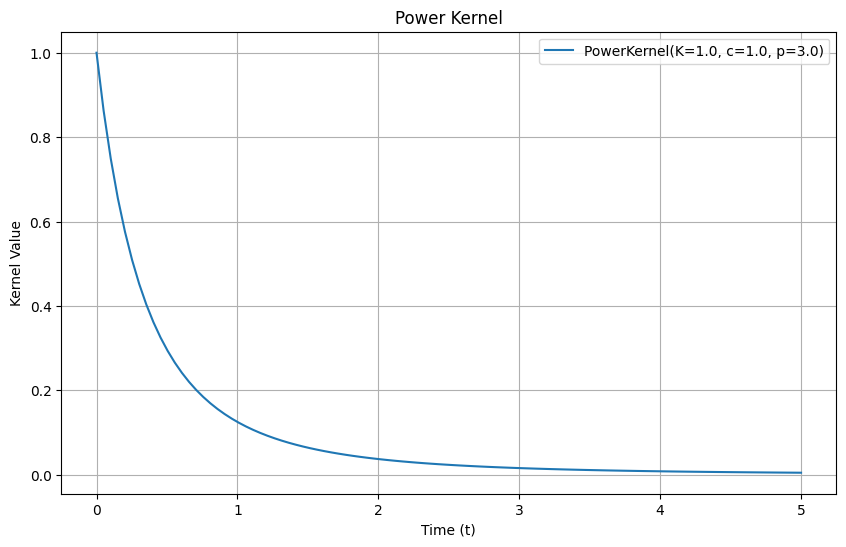

In [ ]:
kernel = PowerKernel(K=1.0, c=1.0, p=3.0)

# Example inputs
t = jnp.linspace(0, 5, 100)  # Time values
his_t = jnp.zeros_like(t)    # Assuming history time is zero for simplicity

# Compute the kernel values
kernel_values = kernel.nu(t, his_t)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t, kernel_values, label='PowerKernel(K=1.0, c=1.0, p=3.0)')
plt.xlabel('Time (t)')
plt.ylabel('Kernel Value')
plt.title('Power Kernel')
plt.legend()
plt.grid(True)  # Ensure grid is enabled
plt.show()

In [ ]:
kernel = TsallisQExpKernel(a=1.0, q=1.5)

# Example inputs
t = jnp.linspace(0, 5, 100)  # Time values
his_t = jnp.zeros_like(t)    # Assuming history time is zero for simplicity

# Compute the kernel values
kernel_values = kernel.nu(t, his_t)

# Plot
# plt.figure(figsize=(10, 6))
# plt.plot(t, kernel_values, label='TsallisQExpKernel(a=1.0, q=1.5)')
# plt.xlabel('Time (t)')
# plt.ylabel('Kernel Value')
# plt.title('Tsallis Q-Exponential Kernel')
# plt.legend()
# plt.grid(True)  # Ensure grid is enabled
# plt.show()

In [ ]:
jnp.expand_dims(t,axis=1)

Array([[0.        ],
       [0.05050505],
       [0.1010101 ],
       [0.15151516],
       [0.2020202 ],
       [0.25252524],
       [0.3030303 ],
       [0.35353535],
       [0.4040404 ],
       [0.45454544],
       [0.5050505 ],
       [0.5555555 ],
       [0.6060606 ],
       [0.65656567],
       [0.7070707 ],
       [0.75757575],
       [0.8080808 ],
       [0.85858583],
       [0.9090909 ],
       [0.9595959 ],
       [1.010101  ],
       [1.060606  ],
       [1.111111  ],
       [1.1616161 ],
       [1.2121212 ],
       [1.2626263 ],
       [1.3131313 ],
       [1.3636364 ],
       [1.4141414 ],
       [1.4646465 ],
       [1.5151515 ],
       [1.5656565 ],
       [1.6161616 ],
       [1.6666666 ],
       [1.7171717 ],
       [1.7676767 ],
       [1.8181818 ],
       [1.8686868 ],
       [1.9191918 ],
       [1.9696969 ],
       [2.020202  ],
       [2.070707  ],
       [2.121212  ],
       [2.1717172 ],
       [2.222222  ],
       [2.2727273 ],
       [2.3232322 ],
       [2.373

In [ ]:
def plot_kernel(beta):
    kernel = ExpKernel(beta=beta)
    t = jnp.linspace(0, 5, 100)  # Time values
    his_t = jnp.zeros_like(t)    # Assuming history time is zero for simplicity
    kernel_values = kernel.nu(t, his_t)

    plt.figure(figsize=(10, 6))
    plt.plot(t, kernel_values, label=f'ExpKernel(beta={beta:.2f})')
    plt.xlabel('Time (t)')
    plt.ylabel('Kernel Value')
    plt.title('Exponential Kernel')
    plt.legend()
    plt.grid(True)  # Grid setting remains unchanged
    plt.show()

# Create an interactive plot
beta_slider = FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Beta:')
interactive_plot = interactive(plot_kernel, beta=beta_slider)
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='Beta:', max=10.0, min=0.1), Output()), _dom_classes=…

# Example usage of kernels

In [ ]:
# Example usage:
# Initialize an instance of PeriodicKernel
kernel = PeriodicKernel(period=2.0)

# Example inputs
t = jnp.array([0.5, 1.5, 2.5])
his_t = jnp.array([0.0, 1.0, 2.0])

# Compute the kernel values
kernel_values = kernel.nu(t, his_t)
print("Kernel values:", kernel_values)

Kernel values: [6.123234e-17 6.123234e-17 6.123234e-17]


In [ ]:
# Example usage:
# Initialize an instance of GaussianKernel
kernel = GaussianKernel(alpha=1.0, sigma=1.0)

# Example inputs
t = jnp.array([0.5, 1.5, 2.5])
his_t = jnp.array([0.0, 1.0, 2.0])

# Compute the kernel values
kernel_values = kernel.nu(t, his_t)
print("Kernel values:", kernel_values)

Kernel values: [0.8824969 0.8824969 0.8824969]


In [ ]:
# Example usage:
# Initialize an instance of LogisticKernel
kernel = LogisticKernel(alpha=1.0, beta=1.0)

# Example inputs
t = jnp.array([0.5, 1.5, 2.5])
his_t = jnp.array([0.0, 1.0, 2.0])

# Compute the kernel values
kernel_values = kernel.nu(t, his_t)
print("Kernel values:", kernel_values)

Kernel values: [0.62245933 0.62245933 0.62245933]


In [ ]:
# Example usage:
# Initialize an instance of RectangularKernel
kernel = RectangularKernel(width=2.0)

# Example inputs
t = jnp.array([0.5, 1.5, 2.5])
his_t = jnp.array([0.0, 1.0, 2.0])

# Compute the kernel values
kernel_values = kernel.nu(t, his_t)
print("Kernel values:", kernel_values)

Kernel values: [0.5 0.5 0.5]


In [ ]:
# Example usage
kernel = TsallisQExpKernel(a=2.0, q=2.0)
t = jnp.array([0.5, 1.5, 2.5])
his_t = jnp.array([0.0, 1.0, 2.0])
kernel_values = kernel.nu(t, his_t)
print("Kernel values:", kernel_values)

# Test
def test_tsallis_qexp_kernel():
    kernel = TsallisQExpKernel(a=2.0, q=2.0)
    t = jnp.array([0.5, 1.5, 2.5])
    his_t = jnp.array([0.0, 1.0, 2.0])
    kernel_values = kernel.nu(t, his_t)
    expected_values = [2.0, 3.0, 4.0]  # Adjust expected values based on your specific kernel and inputs
    assert jnp.allclose(kernel_values, expected_values)

# Run test
test_tsallis_qexp_kernel()

In [ ]:
key_test = random.PRNGKey(21)

In [ ]:
random.poisson(key_test, (10,))

Array(9, dtype=int32)

In [ ]:
D_test = random.uniform(key_test, points_test.shape)

#STHP Simulation

In [ ]:
class TemporalPointProcess(object):
    """
    Marked Temporal Hawkes Process

    A stochastic temporal points generator based on Hawkes process.
    """

    def __init__(self, lam):
        """
        Params:
        """
        # model parameters
        self.lam     = lam

    def _homogeneous_poisson_sampling(self, T=[0, 1], key=None):
        """
        To generate a homogeneous Poisson point pattern in space T, it basically
        takes two steps:
        1. Simulate the number of events n = N(T) occurring in T according to a
        Poisson distribution with mean lam * |T|.
        2. Sample each of the n location according to a uniform distribution on S
        respectively.

        Args:
            lam: intensity (or maximum intensity when used by thining algorithm)
            T:   (min_t, max_t) indicates the range of coordinates.
        Returns:
            samples: point process samples:
            [t1, t2, ..., tn]
        """
        if key is None:
            key = random.PRNGKey(0)

        # sample the number of events from S
        n      = T[1] - T[0]
        N      = random.poisson(key, self.lam.upper_bound() * n,(1,))

        # simulate spatial sequence and temporal sequence separately.
        points = random.uniform(key, (N[0],), minval=T[0], maxval=T[1])

        # sort the sequence regarding the ascending order of the temporal sample.
        points = jnp.sort(points)

        return points

    def _inhomogeneous_poisson_thinning(self, homo_points, verbose, key=None):
        """
        To generate a realization of an inhomogeneous Poisson process in T, this
        function uses a thining algorithm as follows. For a given intensity function
        lam(t):
        1. Define an upper bound max_lam for the intensity function lam(t)
        2. Simulate a homogeneous Poisson process with intensity max_lam.
        3. "Thin" the simulated process as follows,
            a. Compute p = lam(t)/max_lam for each point (t) of the homogeneous
            Poisson process
            b. Generate a sample u from the uniform distribution on (0, 1)
            c. Retain the locations for which u <= p.
        """
        if key is None:
            key = random.PRNGKey(0)

        retained_points = jnp.array([])
        if verbose:
            print("[%s] generate %s samples from homogeneous poisson point process" % \
                (arrow.now(), homo_points.shape), file=sys.stderr)
        # thining samples by acceptance rate.
        D         = random.uniform(key, homo_points.shape)
        for i in range(homo_points.shape[0]):
            # print(i)
            # current time, location and generated historical times and locations.
            t     = homo_points[i]
            his_t = retained_points
            # thinning
            lam_value = self.lam.value(t, his_t)
            lam_bar   = self.lam.upper_bound()

            # - if lam_value is greater than lam_bar, then skip the generation process
            #   and return None.
            # print(lam_value, lam_bar)
            if lam_value > lam_bar:
                if verbose:
                    print("intensity %f is greater than upper bound %f." % (lam_value, lam_bar), file=sys.stderr)
                return None
            # accept
            if lam_value >= D[i] * lam_bar:
                # retained_points.append(homo_points[i])
                retained_points = jnp.concatenate([retained_points, jnp.expand_dims(homo_points[i], axis=0)], axis=0)
            # monitor the process of the generation
            if verbose and i != 0 and i % int(homo_points.shape[0] / 10) == 0:
                print("[%s] %d raw samples have been checked. %d samples have been retained." % \
                    (arrow.now(), i, retained_points.shape[0]), file=sys.stderr)
        # log the final results of the thinning algorithm
        if verbose:
            print("[%s] thining samples %s based on %s." % \
                (arrow.now(), retained_points.shape, self.lam), file=sys.stderr)
        return retained_points


        # def thinning_loop(homo_points, retained_points, lam, D, verbose):
        #   def body_fn(i, retained_points):
        #     t = homo_points[i]
        #     his_t = retained_points
        #     lam_value = lam.value(t, his_t)
        #     lam_upper_bound = lam.upper_bound()

        #     def greater_than_upper_bound(retained_points):
        #       return retained_points

        #     def threshold_crossed(retained_points):
        #       return jnp.concatenate([retained_points, jnp.expand_dims(homo_points[i], axis=0)], axis=0)

        #     if lam_value > lam_upper_bound:
        #       if verbose:
        #         print("Intensity %f is greater than upper bound %f." % (lam_value, lam_upper_bound))
        #       return retained_points

        #     if lam_value >= D[i] * lam_upper_bound:
        #       retained_points = jnp.concatenate([retained_points, jnp.expand_dims(homo_points[i], axis=0)], axis=0)

        #     return retained_points

        #   retained_points = lax.fori_loop(0, homo_points.shape[0], body_fn, retained_points)
        #   return retained_points

        # retained_points = thinning_loop(homo_points, retained_points, self.lam, D, verbose)
        # return retained_points

    def generate(self, T=[0, 1], batch_size=10, min_n_points=5, verbose=True):
        """
        generate spatio-temporal points given lambda and kernel function
        """
        points_list = []
        sizes       = []
        max_len     = 0
        b           = 0
        # generate inhomogeneous poisson points iterately
        pbar = tqdm(total = batch_size, desc="Generating ...")
        while b < batch_size:
            homo_points = self._homogeneous_poisson_sampling(T)
            points      = self._inhomogeneous_poisson_thinning(homo_points, verbose)
            if points is None or len(points) < min_n_points:
                continue
            max_len = points.shape[0] if max_len < points.shape[0] else max_len
            points_list.append(points)
            sizes.append(len(points))
            pbar.update(1)
            b += 1
            if verbose:
                print("[%s] %d-th sequence is generated." % (arrow.now(), b+1), file=sys.stderr)
        # fit the data into a tensor
        data = jnp.zeros((batch_size, max_len))
        for b in range(batch_size):
            data[b, :len(points_list[b])] = points_list[b]
        return data, sizes


In [ ]:
import jax.numpy as jnp

class HawkesLam(object):
    """Intensity of Spatio-temporal Hawkes point process"""
    def __init__(self, mu, kernel, maximum=1e+4):
        self.mu = mu
        self.kernel = kernel
        self.maximum = maximum

    def value(self, t, his_t):
        """
        Return the intensity value at t.
        The last element of his_t is the location t that we are
        going to inspect. Prior to that are the past locations which have
        occurred.
        """
        if len(his_t) > 0:
            val = self.mu + jnp.sum(self.kernel.nu(t, his_t))
        else:
            val = self.mu
        return val

    def upper_bound(self):
        """Return the upper bound of the intensity value"""
        return self.maximum

    def __str__(self):
        return "Hawkes processes"

In [ ]:
def plot_1d_pointprocess(points, lam, T, ngrid=100):
    """
    visualize 1 dimensional point process
    """
    ts      = np.linspace(T[0], T[1], ngrid)
    lamvals = []
    for t in ts:
        his_t  = points[(points <= t) * (points > 0)]
        lamval = lam.value(t, his_t)
        lamvals.append(lamval)

    evals   = []
    print(points)
    for t in points:
        his_t  = points[(points <= t) * (points > 0)]
        lamval = lam.value(t, his_t)
        evals.append(lamval)

    fig, ax = plt.subplots()
    ax.plot(ts, lamvals, linestyle="--", color="grey")
    ax.scatter(points, evals, c="r")
    plt.show()

## simulating thinning algorithm

In [ ]:
mu     = 10
T      = [0., 1.]
beta   = 10.
alpha  = 5.
kernel = ExpKernel(alpha=alpha, beta=beta)
lam    = HawkesLam(mu, kernel, maximum=500)
pp     = TemporalPointProcess(lam)

# generate points
# points, sizes = pp.generate(T=T, batch_size=1000, verbose=False)
# print(sizes)
# plot_1d_pointprocess(points[0], lam, T=T, ngrid=1000)

In [ ]:
t = jnp.array([0.5, 1.5, 2.5])
his_t = jnp.array([0.0, 1.0, 2.0])
jnp.sum(kernel.nu(t, his_t))

Array(0.1010692, dtype=float64)

In [ ]:
points_test = pp._homogeneous_poisson_sampling(T=[0,10])

In [ ]:
key_test = random.PRNGKey(0)

In [ ]:
points_test[2]

Array(0.00488576, dtype=float64)

In [ ]:
D_test = random.uniform(key_test, points_test.shape)

In [ ]:
vlam_value = vmap(lambda i: jnp.greater_equal(lam.value(points_test[i], his_t),1000*D_test[i]))

In [ ]:
# Assuming 'i' is the index variable used in your lambda function
for i in range(len(points_test)):
    print((lambda i: jnp.greater_equal(lam.value(points_test[i], his_t), 1000 * D_test[i]))(i))


In [ ]:
def _inhomogeneous_poisson_thinning():
  retained_points = jnp.array([])
  result = jnp.array([True])
  starting_index = -1
  while result.any():
    vlam_value = vmap(lambda i: jnp.greater_equal(lam.value(points_test[i], retained_points),1000*D_test[i]))
    result = vlam_value(jnp.arange(starting_index+1,points_test.shape[0]))
    index = jnp.where(result)[0][0]
    print(index+starting_index+1)
    retained_points = jnp.concatenate([retained_points, jnp.expand_dims(points_test[index+starting_index+1], axis=0)], axis=0)
    starting_index=index+starting_index+1

  return retained_points

In [ ]:
_inhomogeneous_poisson_thinning()

In [ ]:
result = vlam_value(jnp.arange(0,points_test.shape[0]))

In [ ]:
result.any()

Array(True, dtype=bool)

In [ ]:
points_test[jnp.where(result)[0][0]]

Array(0.00015567, dtype=float64)

In [ ]:
pp._inhomogeneous_poisson_thinning(points_test,verbose=True)

[2024-03-05T17:38:34.233360+00:00] generate (5046,) samples from homogeneous poisson point process
[2024-03-05T17:38:34.516935+00:00] 504 raw samples have been checked. 15 samples have been retained.
[2024-03-05T17:38:34.791967+00:00] 1008 raw samples have been checked. 31 samples have been retained.
[2024-03-05T17:38:35.063962+00:00] 1512 raw samples have been checked. 37 samples have been retained.
[2024-03-05T17:38:35.332712+00:00] 2016 raw samples have been checked. 50 samples have been retained.
[2024-03-05T17:38:35.613507+00:00] 2520 raw samples have been checked. 73 samples have been retained.
[2024-03-05T17:38:35.872032+00:00] 3024 raw samples have been checked. 89 samples have been retained.
[2024-03-05T17:38:36.161887+00:00] 3528 raw samples have been checked. 106 samples have been retained.
[2024-03-05T17:38:36.449419+00:00] 4032 raw samples have been checked. 133 samples have been retained.
[2024-03-05T17:38:36.727666+00:00] 4536 raw samples have been checked. 146 samples h

Array([0.08396448, 0.08603725, 0.08923368, 0.34350372, 0.60418417,
       0.62279049, 0.65633184, 0.80390179, 0.82009015, 0.85322935,
       0.86422097, 0.87548924, 0.93930852, 0.9409949 , 0.9616446 ,
       1.1696867 , 1.20113141, 1.30209566, 1.3134392 , 1.31800975,
       1.36521758, 1.38699506, 1.3999318 , 1.41666447, 1.42242618,
       1.42639931, 1.43359593, 1.4492794 , 1.55920885, 1.61576784,
       1.8964076 , 2.03308048, 2.14228661, 2.20280907, 2.26579181,
       2.2897951 , 2.68382694, 2.97036099, 2.98032   , 2.99868353,
       3.01798817, 3.03807129, 3.17891363, 3.19140404, 3.23755918,
       3.26984186, 3.70254233, 3.71761437, 3.86765229, 3.87714573,
       3.88845351, 3.9243403 , 3.93369879, 3.97331744, 4.00737314,
       4.01045026, 4.09736   , 4.13357772, 4.15513017, 4.16818553,
       4.17240523, 4.21067901, 4.24334901, 4.30933799, 4.44069658,
       4.45874161, 4.49529186, 4.52865548, 4.55101742, 4.56149867,
       4.61720613, 4.63648359, 4.81881989, 4.85320988, 4.92015

In [ ]:
points_test[0]

Array(0.01863718, dtype=float32)

In [ ]:
test = jnp.array([])

In [ ]:
result = jnp.concatenate([test, jnp.expand_dims(points_test[1], axis=0)])

In [ ]:
result

Array([0.06853938], dtype=float32)

#STSCP (Temporal)

In [ ]:
!pip install arrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 726.1 kB/s eta 0:00:00


In [ ]:
import pymc as pm

In [ ]:
pm.gp.cov.Exponential(2,4)

In [ ]:
from jax import config

config.update("jax_enable_x64", True)
# import gpjax as gpx
from jax import grad, jit, lax, vmap
import jax.numpy as jnp
from jax import random
import optax as ox

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
from ipywidgets import interactive, FloatSlider
import ipywidgets as widgets

In [ ]:
import sys
# import utils
import arrow
from tqdm import tqdm
from scipy.stats import norm

$EXP(α,β) = α e^{-βt}$


In [ ]:
class ExpKernel(object):
    """
    Kernel function including the diffusion-type model proposed by Musmeci and
    Vere-Jones (1992).
    """
    def __init__(self, alpha=1., beta=1.):
        self.alpha = alpha
        self.beta = beta

    def nu(self, t, his_t):
        delta_t = t - his_t
        return self.alpha * jnp.exp(- self.beta * delta_t)

In [ ]:
class GaussianKernel(object):
    """
    Kernel function based on the Gaussian kernel.
    """
    def __init__(self, alpha=1.0, sigma=1.0):
        self.alpha = alpha
        self.sigma = sigma

    def nu(self, t, his_t):
        delta_t = t - his_t
        return self.alpha * jnp.exp(-0.5 * (delta_t / self.sigma)**2)

In [ ]:
class STSCP(object):
    """
    Self correcting Temporal point Process

    """

    def __init__(self, lam):
        """
        Params:
        """
        # model parameters
        self.lam     = lam

    def _homogeneous_poisson_sampling(self, T=[0, 1], key=None):
        """
        To generate a homogeneous Poisson point pattern in space T, it basically
        takes two steps:
        1. Simulate the number of events n = N(T) occurring in T according to a
        Poisson distribution with mean lam * |T|.
        2. Sample each of the n location according to a uniform distribution on S
        respectively.

        Args:
            lam: intensity (or maximum intensity when used by thining algorithm)
            T:   (min_t, max_t) indicates the range of coordinates.
        Returns:
            samples: point process samples:
            [t1, t2, ..., tn]
        """
        if key is None:
            key = random.PRNGKey(0)

        # sample the number of events from S
        n      = T[1] - T[0]
        N      = random.poisson(key, self.lam.upper_bound() * n,(1,))

        points = random.uniform(key, (N[0],), minval=T[0], maxval=T[1])

        points = jnp.sort(points)
        return points



    def _inhomogeneous_poisson_thinning(self, homo_points, verbose, plot, key=None):
        """
        To generate a realization of an inhomogeneous Poisson process in T, this
        function uses a thinning algorithm as follows. For a given intensity function
        lam(t):
        1. Define an upper bound max_lam for the intensity function lam(t)
        2. Simulate a homogeneous Poisson process with intensity max_lam.
        3. "Thin" the simulated process as follows,
            a. Compute p = lam(t)/max_lam for each point (t) of the homogeneous
            Poisson process
            b. Generate a sample u from the uniform distribution on (0, 1)
            c. Retain the locations for which u <= p.
        """
        if key is None:
            key = random.PRNGKey(0)

        retained_points = jnp.array([])
        if verbose:
            print("[%s] generate %s samples from homogeneous Poisson point process" % \
                (arrow.now(), homo_points.shape), file=sys.stderr)


        # Thinning samples by acceptance rate.
        D = random.uniform(key, homo_points.shape)
        if plot:
            ref_y = [2]*homo_points.shape[0]

        for i in range(homo_points.shape[0]):
            # Current time, location and generated historical times and locations.
            t = homo_points[i]
            his_t = retained_points

            # Thinning
            lam_value = self.lam.value(self.lam.mu, his_t, t)
            lam_bar   = self.lam.lamb_max

            # - if lam_value is greater than lam_bar, then skip the generation process
            #   and return None.
            if lam_value > lam_bar:
                if verbose:
                    print("intensity %f is greater than upper bound %f." % (lam_value, lam_bar), file=sys.stderr)
                return None
            # Accept
            if lam_value >= D[i] * lam_bar:
                retained_points = jnp.concatenate([retained_points, jnp.expand_dims(homo_points[i], axis=0)], axis=0)

            # Monitor the process of the generation
            if verbose and i != 0 and i % int(homo_points.shape[0] / 20) == 0:
                print("[%s] %d raw samples have been checked. %d samples have been retained." % \
                    (arrow.now(), i, retained_points.shape[0]), file=sys.stderr)

            if plot and i != 0 and i % int(homo_points.shape[0] / 10) == 0:
                # Plot homo_points[i:] and retained_points
                plt.figure(figsize=(8, 2))
                plt.scatter(homo_points[i:], ref_y[i:], color='blue')
                plt.scatter(retained_points, ref_y[:retained_points.shape[0]], color='blue')
                plt.show()
                plt.pause(0.1)


        # Log the final results of the thinning algorithm
        if verbose:
            print("[%s] thinning samples %s based on %s." % \
                (arrow.now(), retained_points.shape, self.lam), file=sys.stderr)
        return retained_points



    def generate(self, T=[0, 1], batch_size=10, min_n_points=5, verbose=True):
        """
        generate spatio-temporal points given lambda and kernel function
        """
        points_list = []
        sizes       = []
        max_len     = 0
        b           = 0
        # generate inhomogeneous poisson points iterately
        pbar = tqdm(total = batch_size, desc="Generating ...")
        while b < batch_size:
            homo_points = self._homogeneous_poisson_sampling(T)
            points      = self._inhomogeneous_poisson_thinning(homo_points, verbose)
            if points is None or len(points) < min_n_points:
                continue
            max_len = points.shape[0] if max_len < points.shape[0] else max_len
            points_list.append(points)
            sizes.append(len(points))
            pbar.update(1)
            b += 1
            if verbose:
                print("[%s] %d-th sequence is generated." % (arrow.now(), b+1), file=sys.stderr)
        # fit the data into a tensor
        data = jnp.zeros((batch_size, max_len))
        for b in range(batch_size):
            data[b, :len(points_list[b])] = points_list[b]
        return data, sizes

    def generate_batch(self, t_start, t_num, mu, verbose=False):
        if verbose:
            print(f"Generating events from t={t_start} to t={t_start + self.max_history}")

        t_end = self.max_history
        t = 0
        his_s = jnp.zeros((0, 2))
        his_t = jnp.array([])

        t_range = jnp.linspace(0, t_end, t_num)[1:]
        lambs = []

        while True:
            # Calculate the max intensity
            lamb_t = self.lamb_t(mu, his_s, t)
            l = 2 / lamb_t
            m = lamb_t * jnp.exp(self.beta*l)
            delta_t = jax.random.exponential(1.0 / m)

            if t + delta_t > t_end:
                break
            if delta_t > l:
                t += l
                continue
            else:
                t += delta_t
                new_lamb_t = self.lamb_t(mu, his_s, t)
                if new_lamb_t / m >= jnp.random.uniform(): # Accept the sample
                    lamb_st = self.lamb_St(mu, his_s, t)

                    if verbose:
                        print("----")
                        print(f"t:  {t + t_start}")
                        print(f"λt: {new_lamb_t}")

                    p = lamb_st / jnp.sum(lamb_st)
                    # Draw a location
                    i = jnp.argmax(jax.random.multinomial(p, 1))
                    his_s = jnp.vstack((his_s, self.s_grids[i]))
                    his_t = jnp.append(his_t, t)

        if verbose:
            print("===")

        # Calculate lamb_st
        for t in t_range:
            lambs.append(self.lamb_St(mu, his_s[his_t < t], t))
        return t_range + t_start, lambs, his_s, his_t + t_start

In [ ]:
class SelfCorrectingLam(object):
    """Intensity of Self correcting Spatio-temporal point process"""
    def __init__(self, mu, tr_kernel, alpha, beta, lamb_max=10, maximum=1e+4):
        self.mu = mu
        self.tr_kernel = tr_kernel #triggering kernel
        self.alpha = alpha
        self.beta = beta
        self.lamb_max = lamb_max
        self.maximum = maximum

        #def lamb_st(self, mu, his_s, s, t):
        #i = self.stoi(s)
        #lamb_st = mu[i] * jnp.exp(self.g0_mat[i] * self.beta * t - self.alpha * jnp.sum(self.g2_mats[self.stoi(his_s), i]))
        #return jnp.minimum(self.lamb_max * jnp.ones(lamb_st.shape), lamb_st)

    def value(self, mu, his_t, t):
        """
        taking exponential kernel for g1(t,ti)
        taking gaussian kernel for g0(s) and g2(s,si)
        """
        val = self.mu * jnp.exp(self.beta * t - self.alpha * jnp.sum(self.tr_kernel.nu(t,his_t)))
        return val

    def upper_bound(self):
        """Return the upper bound of the intensity value"""
        return self.maximum

    def __str__(self):
        return "Self Correcting processes"

In [ ]:
tr_kernel = ExpKernel()
mu     = 1
T      = [0., 1.]
beta   = 0.2
alpha  = 0.2
lam = SelfCorrectingLam(mu, tr_kernel=tr_kernel, alpha=alpha, beta=beta, maximum=500)
pp     = STSCP(lam)

In [ ]:
t = jnp.array([0.5, 1.5, 2.5])
his_t = jnp.array([0.0, 1.0, 2.0])

In [ ]:
print(lam.value(mu, his_t[0],t[0]))

0.9789192402456125


In [ ]:
points_test = pp._homogeneous_poisson_sampling()

In [ ]:
print(len(points_test))

515


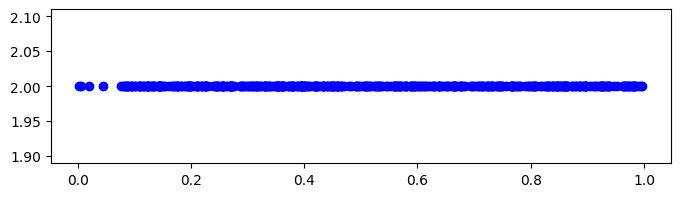

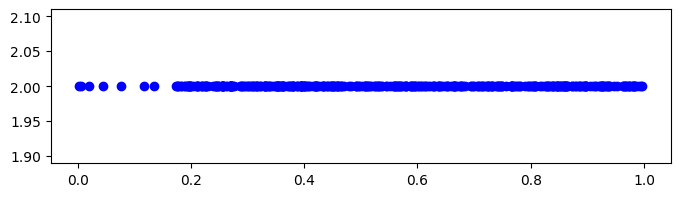

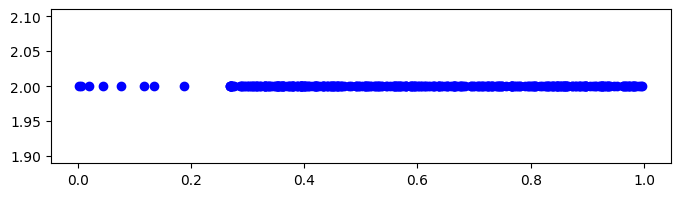

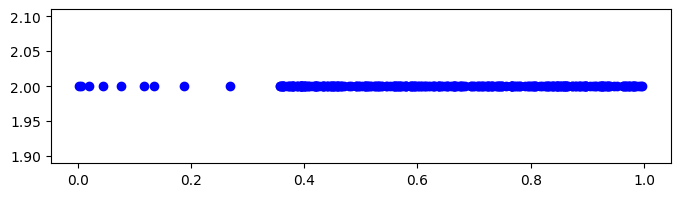

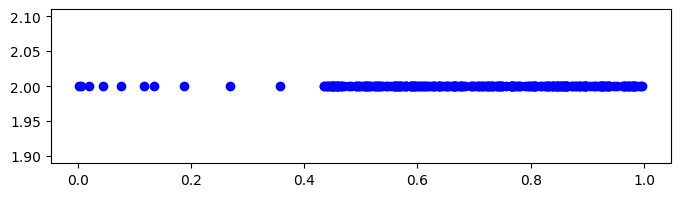

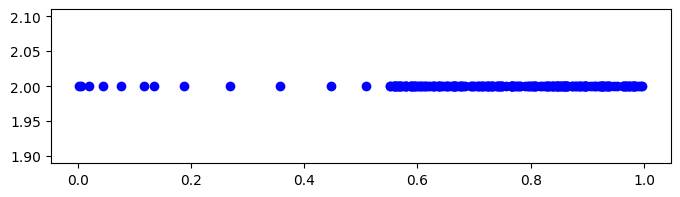

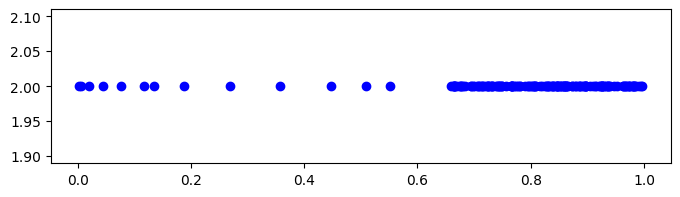

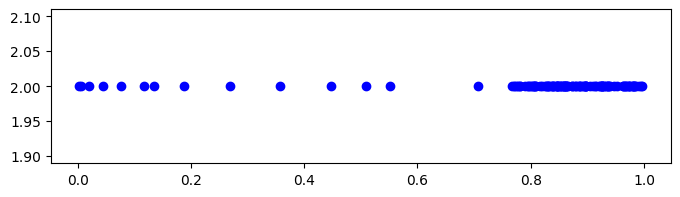

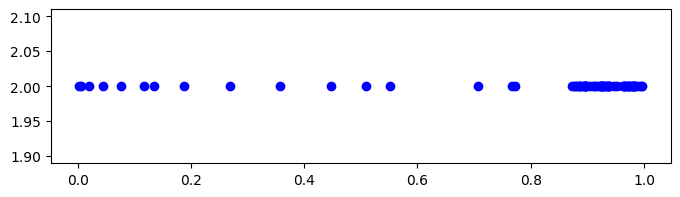

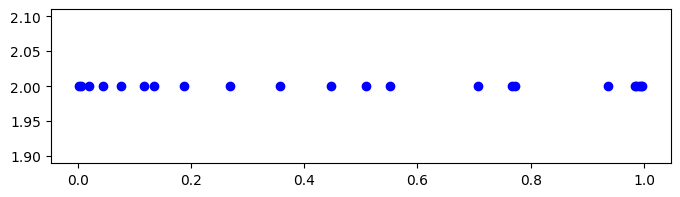

Array([0.00208933, 0.00612414, 0.02038794, 0.04516973, 0.07585184,
       0.11686764, 0.13424701, 0.18767115, 0.26919512, 0.35820035,
       0.44687287, 0.51003205, 0.55085505, 0.70711624, 0.7677081 ,
       0.77172825, 0.93648535], dtype=float64)

In [ ]:
pp._inhomogeneous_poisson_thinning(points_test, verbose=0, plot=1)

#STSCP V2 (Spatio-Temporal)

In [ ]:
!pip install arrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
import pymc as pm

In [ ]:
from jax import config

config.update("jax_enable_x64", True)
# import gpjax as gpx
from jax import grad, jit, lax, vmap
import jax.numpy as jnp
from jax import random
import optax as ox

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, FloatSlider
import ipywidgets as widgets

In [ ]:
import sys
# import utils
import arrow
from tqdm import tqdm
from scipy.stats import norm

In [ ]:
def plot_3d_points(points1, points2):
    # Extract x, y, z coordinates from the points arrays
    x_values1, y_values1, z_values1 = points1[:, 0], points1[:, 1], points1[:, 2]
    x_values2, y_values2, z_values2 = points2[:, 0], points2[:, 1], points2[:, 2]

    # Create figure and 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot points from the first array
    ax.scatter(x_values1, y_values1, z_values1, color='indigo')
    ax.scatter(x_values2, y_values2, z_values2, color='indigo')

    # Set labels and title
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('y')

    plt.show()

$EXP(α,β) = α e^{-βt}$


In [ ]:
class ExpKernel(object):
    """
    Kernel function including the diffusion-type model proposed by Musmeci and
    Vere-Jones (1992).
    """
    def __init__(self, alpha=1., beta=1.):
        self.alpha = alpha
        self.beta = beta

    def nu(self, t, his_t):
        delta_t = t - his_t
        return self.alpha * jnp.exp(- self.beta * delta_t)

$Std. Diffusion$   $\nu(s,t) = \frac{C}{2 \pi \sigma_x \sigma_y \Delta t} \exp\left(-\beta \Delta t\right) \exp\left(-\frac{\left(\frac{\Delta x}{\sigma_x}\right)^2 + \left(\frac{\Delta y}{\sigma_y}\right)^2}{2 \Delta t}\right)$


In [ ]:
class StdDiffusionKernel(object):
    """
    Kernel function including the Gaussian diffusion-type model proposed by Musmeci and
    Vere-Jones (1992).
    Applicable for spatio temporal points
    """
    def __init__(self, C=1., beta=1., sigma_x=1., sigma_y=1.):
        self.C       = C
        self.beta    = beta
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y

    def nu(self, s, his_s, t, his_t):
        delta_t = t - his_t
        his_s_x = lax.slice_in_dim(his_s,0,1,axis=1)
        his_s_y = lax.slice_in_dim(his_s,1,2,axis=1)
        delta_x = s[0] - his_s_x
        delta_y = s[1] - his_s_y
        #NOTE: assumes first column has x values and second column has y values
        return jnp.exp(- self.beta * delta_t) * \
            (self.C / (2 * jnp.pi * self.sigma_x * self.sigma_y * delta_t)) * \
            jnp.exp((- 1. / (2 * delta_t)) * \
                ((jnp.square(delta_x) / jnp.square(self.sigma_x)) + \
                (jnp.square(delta_y) / jnp.square(self.sigma_y))))

$\begin{align*}
\text{Gaussian   } \nu &= \exp\left(-\beta \Delta t\right) \times \\
&\quad \left(\frac{C}{2\pi \sigma_x \sigma_y \Delta t \sqrt{1 - \rho^2}}\right) \times \\
&\quad \exp\left(-\frac{1}{2\Delta t (1 - \rho^2)}\left(\frac{\left(\Delta x - \mu_x\right)^2}{\sigma_x^2} + \frac{\left(\Delta y - \mu_y\right)^2}{\sigma_y^2} - \frac{2\rho \left(\Delta x - \mu_x\right) \left(\Delta y - \mu_y\right)}{\sigma_x \sigma_y}\right)\right)
\end{align*}$

In [ ]:
class GaussianDiffusionKernel(object):
    """
    A Gaussian diffusion kernel function based on the standard kernel function proposed
    by Musmeci and Vere-Jones (1992). The angle and shape of diffusion ellipse is able
    to vary according to the location.
    """
    def __init__(self, mu_x=0.5, mu_y=0.5, sigma_x=1., sigma_y=1., rho=0., beta=1., C=1.):
        # kernel parameters
        self.C                     = C # kernel constant
        self.beta                  = beta
        self.mu_x, self.mu_y       = mu_x, mu_y #spatial mean of x and y
        self.sigma_x, self.sigma_y = sigma_x, sigma_y
        self.rho                   = rho

    def nu(self, s, his_s, t, his_t):
        delta_t = t - his_t
        his_s_x = lax.slice_in_dim(his_s,0,1,axis=1)
        his_s_y = lax.slice_in_dim(his_s,1,2,axis=1)
        delta_x = s[0] - his_s_x
        delta_y = s[1] - his_s_y
        gaussian_val = np.exp(- self.beta * delta_t) * \
            (self.C / (2 * np.pi * self.sigma_x * self.sigma_y * delta_t * np.sqrt(1 - np.square(self.rho)))) * \
            np.exp((- 1. / (2 * delta_t * (1 - np.square(self.rho)))) * \
                ((np.square(delta_x - self.mu_x) / np.square(self.sigma_x)) + \
                (np.square(delta_y - self.mu_y) / np.square(self.sigma_y)) - \
                (2 * self.rho * (delta_x - self.mu_x) * (delta_y - self.mu_y) / (self.sigma_x * self.sigma_y))))
        return gaussian_val

In [ ]:
class STSCP(object):
    """
    Self correcting Temporal point Process

    """

    def __init__(self, lam):
        """
        Params:
        """
        # model parameters
        self.lam     = lam


    def _homogeneous_poisson_sampling(self, T=[0, 1], S=[[0, 1], [0, 1]], seed=None):
        """
        To generate a homogeneous Poisson point pattern in space S X T, it basically
        takes two steps:
        1. Simulate the number of events n = N(S) occurring in S according to a
        Poisson distribution with mean lam * |S X T|.
        2. Sample each of the n location according to a uniform distribution on S
        respectively.

        Args:
            lam: intensity (or maximum intensity when used by thining algorithm)
            S:   [(min_t, max_t), (min_x, max_x), (min_y, max_y), ...] indicates the
                range of coordinates regarding a square (or cubic ...) region.
        Returns:
            samples: point process samples:
            [(t1, x1, y1), (t2, x2, y2), ..., (tn, xn, yn)]
        """
        # sample the number of events from S
        n      = T[1] - T[0]
        if seed is None:
          key = random.PRNGKey(6)
          key_spatial = random.PRNGKey(5)
          key_time = random.PRNGKey(3)

        else:
          key = random.PRNGKey(seed)
          key_spatial = random.PRNGKey(seed+3)
          key_time = random.PRNGKey(seed+7)

        N = random.poisson(key, 100* n, shape=(1,))

        # Sample spatial points
        sp_x = random.uniform(key_spatial, shape=(N[0],), minval=S[0][0], maxval=S[0][1])
        sp_y = random.uniform(key_spatial, shape=(N[0],), minval=S[1][0], maxval=S[1][1])

        # Sample time points
        time_points = random.uniform(key_time, shape=(N[0],), minval=T[0], maxval=T[1])

        sp_x = jnp.expand_dims(sp_x, axis=1)
        sp_y = jnp.expand_dims(sp_y, axis=1)
        time_points = jnp.expand_dims(time_points, axis=1)

        # Concatenate time and spatial points
        points = jnp.concatenate((time_points, sp_x, sp_y), axis=1)
        points = points[points[:, 0].argsort()]

        return points


    def _inhomogeneous_poisson_thinning(self, homo_points, verbose, plot, key=None):
        """
        To generate a realization of an inhomogeneous Poisson process in T, this
        function uses a thining algorithm as follows. For a given intensity function
        lam(t):
        1. Define an upper bound max_lam for the intensity function lam(t)
        2. Simulate a homogeneous Poisson process with intensity max_lam.
        3. "Thin" the simulated process as follows,
            a. Compute p = lam(t)/max_lam for each point (t) of the homogeneous
            Poisson process
            b. Generate a sample u from the uniform distribution on (0, 1)
            c. Retain the locations for which u <= p.
        """
        if key is None:
            key = random.PRNGKey(0)

        retained_points = jnp.zeros((1, 3))

        if verbose:
            print("[%s] generate %s samples from homogeneous poisson point process" % \
                (arrow.now(), homo_points.shape), file=sys.stderr)
        # thining samples by acceptance rate.
        D = random.uniform(key, (len(homo_points),1))
        for i in range(points_test.shape[0]):
            # current time, location and generated historical times and locations.
            t = homo_points[i,0] # Extracting temporal value from the first column
            s = homo_points[i,1:]  # Extracting spatial coordinates from the second and third columns
            his_s = lax.slice_in_dim(retained_points,1,3,axis=1)
            his_t = lax.slice_in_dim(retained_points,0,1,axis=1)

            # - if lam_value is greater than lam_bar, then skip the generation process and return None.
            # print(lam_value, lam_bar)
            lam_value = self.lam.value(mu, his_s, his_t, s, t)
            lam_bar   = self.lam.lamb_max

            #discard if exceeds max
            if lam_value > lam_bar:
                if verbose:
                    print("intensity %f is greater than upper bound %f." % (lam_value, lam_bar), file=sys.stderr)
                return None
            # accept
            if lam_value >= D[i] * lam_bar:
                retained_points = jnp.concatenate([retained_points, jnp.expand_dims(points_test[i,:], axis=0)], axis=0)
            # monitor the process of the generation
            if verbose and i != 0 and i % int(homo_points.shape[0] / 10) == 0:
                print("[%s] %d raw samples have been checked. %d samples have been retained." % \
                    (arrow.now(), i, retained_points.shape[0]), file=sys.stderr)

            if plot and i != 0 and i % int(homo_points.shape[0] / 10) == 0:
              screened_points = lax.slice_in_dim(homo_points, i+1, len(homo_points), axis=0)
              plot_3d_points(retained_points, screened_points)
        # log the final results of the thinning algorithm
        if verbose:
            print("[%s] thining samples %s based on %s." % \
                (arrow.now(), retained_points.shape, self.lam), file=sys.stderr)
        return retained_points


    def generate(self, T=[0, 1], batch_size=10, min_n_points=5, verbose=True):
        """
        generate spatio-temporal points given lambda and kernel function
        """
        points_list = []
        sizes       = []
        max_len     = 0
        b           = 0
        # generate inhomogeneous poisson points iterately
        pbar = tqdm(total = batch_size, desc="Generating ...")
        while b < batch_size:
            homo_points = self._homogeneous_poisson_sampling(T)
            points      = self._inhomogeneous_poisson_thinning(homo_points, verbose)
            if points is None or len(points) < min_n_points:
                continue
            max_len = points.shape[0] if max_len < points.shape[0] else max_len
            points_list.append(points)
            sizes.append(len(points))
            pbar.update(1)
            b += 1
            if verbose:
                print("[%s] %d-th sequence is generated." % (arrow.now(), b+1), file=sys.stderr)
        # fit the data into a tensor
        data = jnp.zeros((batch_size, max_len))
        for b in range(batch_size):
            data[b, :len(points_list[b])] = points_list[b]
        return data, sizes

    def generate_batch(self, t_start, t_num, mu, verbose=False):
        if verbose:
            print(f"Generating events from t={t_start} to t={t_start + self.max_history}")

        t_end = self.max_history
        t = 0
        his_s = jnp.zeros((0, 2))
        his_t = jnp.array([])

        t_range = jnp.linspace(0, t_end, t_num)[1:]
        lambs = []

        while True:
            # Calculate the max intensity
            lamb_t = self.lamb_t(mu, his_s, t)
            l = 2 / lamb_t
            m = lamb_t * jnp.exp(self.beta*l)
            delta_t = jax.random.exponential(1.0 / m)

            if t + delta_t > t_end:
                break
            if delta_t > l:
                t += l
                continue
            else:
                t += delta_t
                new_lamb_t = self.lamb_t(mu, his_s, t)
                if new_lamb_t / m >= jnp.random.uniform(): # Accept the sample
                    lamb_st = self.lamb_St(mu, his_s, t)

                    if verbose:
                        print("----")
                        print(f"t:  {t + t_start}")
                        print(f"λt: {new_lamb_t}")

                    p = lamb_st / jnp.sum(lamb_st)
                    # Draw a location
                    i = jnp.argmax(jax.random.multinomial(p, 1))
                    his_s = jnp.vstack((his_s, self.s_grids[i]))
                    his_t = jnp.append(his_t, t)

        if verbose:
            print("===")

        # Calculate lamb_st
        for t in t_range:
            lambs.append(self.lamb_St(mu, his_s[his_t < t], t))
        return t_range + t_start, lambs, his_s, his_t + t_start

In [ ]:
class SelfCorrectingLam(object):
    """Intensity of Self correcting Spatio-temporal point process"""
    def __init__(self, mu, kernel, tr_kernel, alpha, beta, lamb_max=10, maximum=1e+4):
        self.mu = mu
        self.kernel = kernel
        self.tr_kernel = tr_kernel #triggering kernel
        self.alpha = alpha
        self.beta = beta
        self.lamb_max = lamb_max
        self.maximum = maximum

    def value(self, mu, his_s, his_t, s, t):
        """
        taking gaussian kernel for g0(s) and g2(s,si)
        """
        z = jnp.array([[0, 0]])
        val = self.mu * jnp.exp(jnp.sum(self.kernel.nu(s,z,t,his_t)) * self.beta * t - self.alpha * jnp.sum(self.kernel.nu(s,his_s,t,his_t)) * jnp.sum(self.tr_kernel.nu(t,his_t)))
        return val

    def upper_bound(self):
        """Return the upper bound of the intensity value"""
        return self.maximum

    def __str__(self):
        return "Self Correcting processes"

In [ ]:
kernel = StdDiffusionKernel()
tr_kernel = ExpKernel()
mu     = 1
beta   = 0.2
alpha  = 0.2
lam    = SelfCorrectingLam(mu, kernel, tr_kernel, alpha, beta, maximum=500)
pp     = STSCP(lam)

In [ ]:
points_test = pp._homogeneous_poisson_sampling()

In [ ]:
print(points_test)

[[0.00559961 0.15273899 0.15273899]
 [0.00566934 0.98800941 0.98800941]
 [0.02294777 0.25506831 0.25506831]
 [0.0288295  0.66909965 0.66909965]
 [0.03489307 0.02789994 0.02789994]
 [0.04111579 0.37372749 0.37372749]
 [0.07026454 0.85555534 0.85555534]
 [0.07031446 0.46683053 0.46683053]
 [0.09364368 0.94526954 0.94526954]
 [0.10390707 0.89282518 0.89282518]
 [0.12059137 0.74424885 0.74424885]
 [0.13015705 0.95607382 0.95607382]
 [0.13525245 0.04098715 0.04098715]
 [0.15439646 0.13964323 0.13964323]
 [0.15685841 0.70039243 0.70039243]
 [0.15891373 0.69050045 0.69050045]
 [0.15898898 0.47614301 0.47614301]
 [0.16420222 0.15155303 0.15155303]
 [0.18242099 0.53964123 0.53964123]
 [0.18671854 0.84838198 0.84838198]
 [0.20074602 0.15527163 0.15527163]
 [0.20231214 0.32653461 0.32653461]
 [0.21849108 0.30213223 0.30213223]
 [0.21942205 0.46650495 0.46650495]
 [0.23589549 0.03988649 0.03988649]
 [0.23617965 0.21551138 0.21551138]
 [0.24642596 0.24412293 0.24412293]
 [0.25794922 0.99719578 0.99

In [ ]:
points_test.shape[0]

107

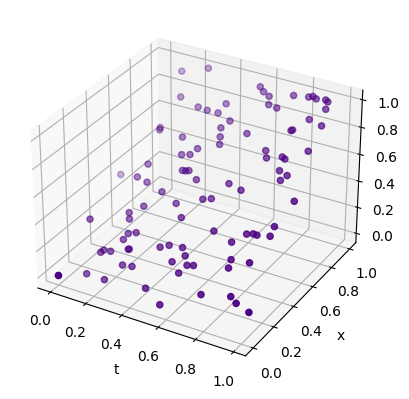

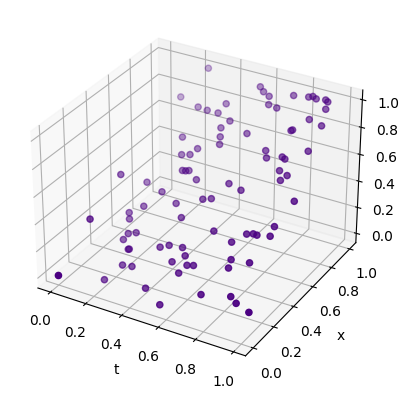

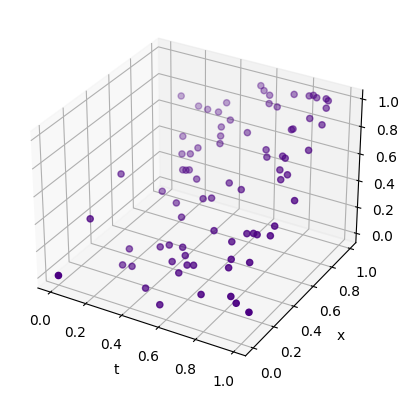

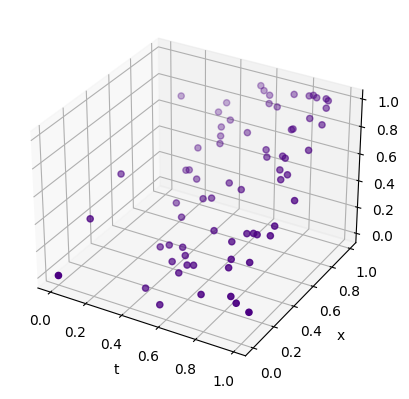

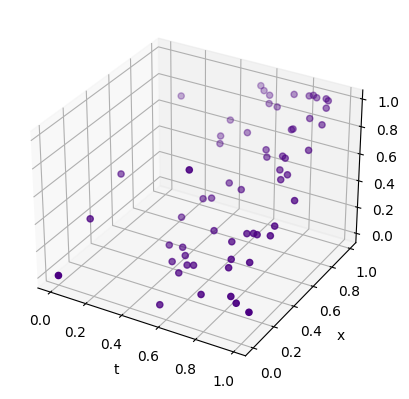

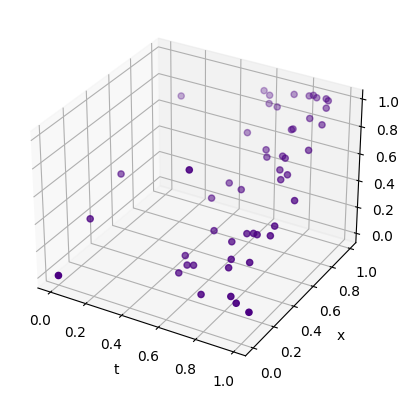

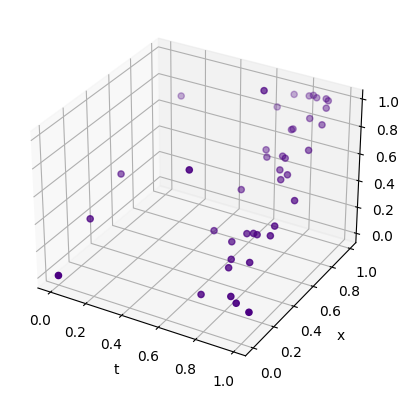

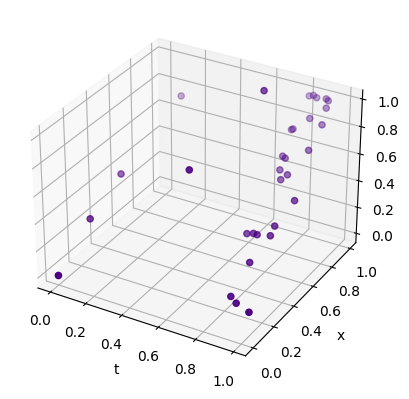

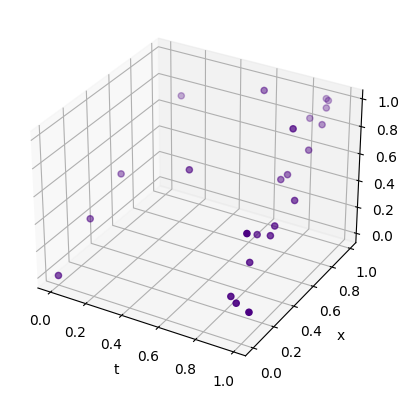

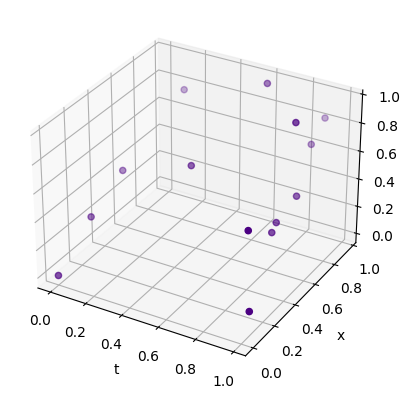

Array([[0.        , 0.        , 0.        ],
       [0.02294777, 0.25506831, 0.25506831],
       [0.07031446, 0.46683053, 0.46683053],
       [0.18671854, 0.84838198, 0.84838198],
       [0.39973015, 0.56034506, 0.56034506],
       [0.5870754 , 0.95922943, 0.95922943],
       [0.81222903, 0.83563347, 0.83563347],
       [0.81701442, 0.37873973, 0.37873973],
       [0.99007416, 0.08864814, 0.08864814]], dtype=float64)

In [ ]:
pp._inhomogeneous_poisson_thinning(points_test, verbose=0, plot=1)

In [ ]:
pp._inhomogeneous_poisson_thinning(points_test, verbose=1)

[2024-05-15T04:08:35.895968+00:00] generate (107, 3) samples from homogeneous poisson point process
[2024-05-15T04:08:36.529103+00:00] 10 raw samples have been checked. 3 samples have been retained.
[2024-05-15T04:08:36.847559+00:00] 20 raw samples have been checked. 4 samples have been retained.
[2024-05-15T04:08:36.870636+00:00] 30 raw samples have been checked. 4 samples have been retained.
[2024-05-15T04:08:36.889917+00:00] 40 raw samples have been checked. 4 samples have been retained.
[2024-05-15T04:08:37.214355+00:00] 50 raw samples have been checked. 5 samples have been retained.
[2024-05-15T04:08:37.233577+00:00] 60 raw samples have been checked. 5 samples have been retained.
[2024-05-15T04:08:37.570773+00:00] 70 raw samples have been checked. 6 samples have been retained.
[2024-05-15T04:08:37.594449+00:00] 80 raw samples have been checked. 6 samples have been retained.
[2024-05-15T04:08:38.228894+00:00] 90 raw samples have been checked. 8 samples have been retained.
[2024-05-

Array([[0.        , 0.        , 0.        ],
       [0.02294777, 0.25506831, 0.25506831],
       [0.07031446, 0.46683053, 0.46683053],
       [0.18671854, 0.84838198, 0.84838198],
       [0.39973015, 0.56034506, 0.56034506],
       [0.5870754 , 0.95922943, 0.95922943],
       [0.81222903, 0.83563347, 0.83563347],
       [0.81701442, 0.37873973, 0.37873973],
       [0.99007416, 0.08864814, 0.08864814]], dtype=float64)

In [ ]:
kernel = GaussianDiffusionKernel()
tr_kernel = ExpKernel()
mu     = 1
beta   = 0.2
alpha  = 0.2
lam    = SelfCorrectingLam(mu, kernel, tr_kernel, alpha, beta, maximum=500)
pp     = STSCP(lam)

In [ ]:
points_test = pp._homogeneous_poisson_sampling()

In [ ]:
pp._inhomogeneous_poisson_thinning(points_test, verbose=1)

[2024-05-15T04:39:57.471782+00:00] generate (107, 3) samples from homogeneous poisson point process
[2024-05-15T04:39:57.618519+00:00] 10 raw samples have been checked. 2 samples have been retained.
[2024-05-15T04:39:57.640078+00:00] 20 raw samples have been checked. 2 samples have been retained.
[2024-05-15T04:39:57.668320+00:00] 30 raw samples have been checked. 2 samples have been retained.
[2024-05-15T04:39:57.761230+00:00] 40 raw samples have been checked. 3 samples have been retained.
[2024-05-15T04:39:57.847287+00:00] 50 raw samples have been checked. 4 samples have been retained.
[2024-05-15T04:39:57.870976+00:00] 60 raw samples have been checked. 4 samples have been retained.
[2024-05-15T04:39:57.953249+00:00] 70 raw samples have been checked. 5 samples have been retained.
[2024-05-15T04:39:58.047831+00:00] 80 raw samples have been checked. 7 samples have been retained.
[2024-05-15T04:39:58.195264+00:00] 90 raw samples have been checked. 8 samples have been retained.
[2024-05-

Array([[0.        , 0.        , 0.        ],
       [0.02294777, 0.25506831, 0.25506831],
       [0.36720216, 0.55337809, 0.55337809],
       [0.39973015, 0.56034506, 0.56034506],
       [0.5870754 , 0.95922943, 0.95922943],
       [0.69558938, 0.54127989, 0.54127989],
       [0.80335526, 0.22970052, 0.22970052],
       [0.81701442, 0.37873973, 0.37873973],
       [0.89081093, 0.27322602, 0.27322602],
       [0.91264797, 0.10709816, 0.10709816],
       [0.99007416, 0.08864814, 0.08864814]], dtype=float64)

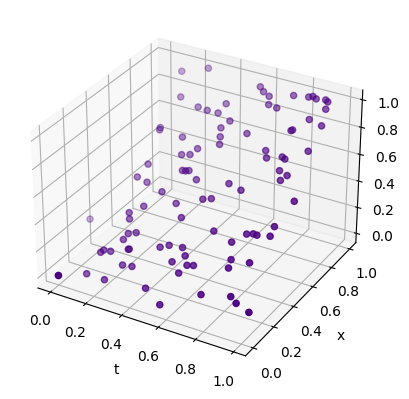

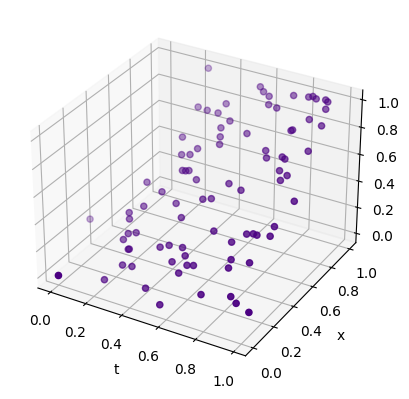

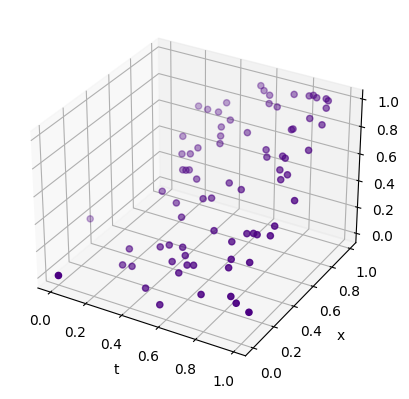

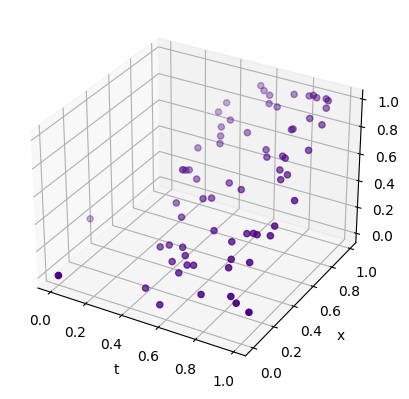

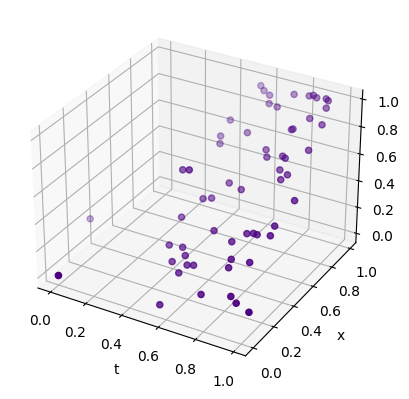

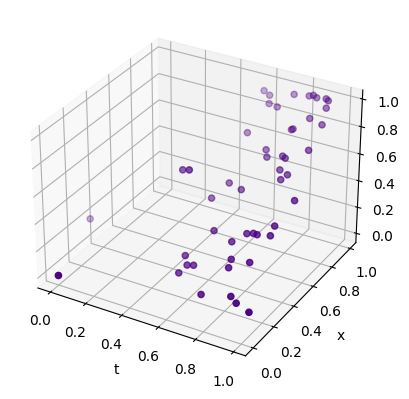

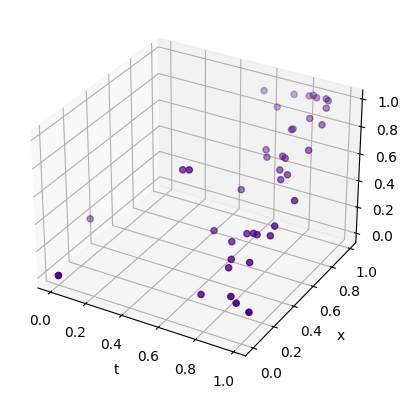

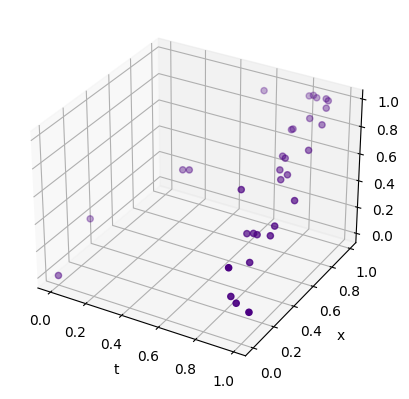

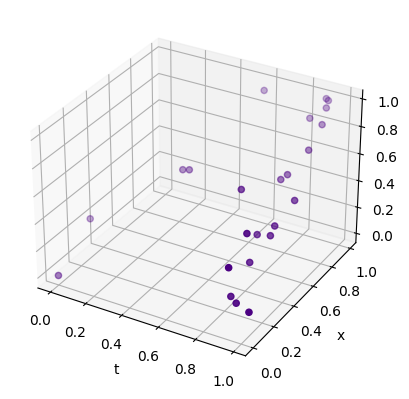

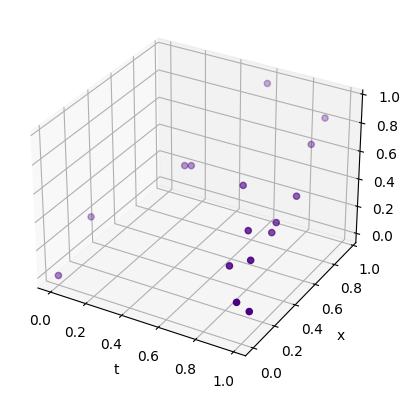

Array([[0.        , 0.        , 0.        ],
       [0.02294777, 0.25506831, 0.25506831],
       [0.36720216, 0.55337809, 0.55337809],
       [0.39973015, 0.56034506, 0.56034506],
       [0.5870754 , 0.95922943, 0.95922943],
       [0.69558938, 0.54127989, 0.54127989],
       [0.80335526, 0.22970052, 0.22970052],
       [0.81701442, 0.37873973, 0.37873973],
       [0.89081093, 0.27322602, 0.27322602],
       [0.91264797, 0.10709816, 0.10709816],
       [0.99007416, 0.08864814, 0.08864814]], dtype=float64)

In [ ]:
pp._inhomogeneous_poisson_thinning(points_test, verbose=0, plot=1)